<a href="https://colab.research.google.com/github/CaioLSouza/my_portfolio/blob/main/Projeto_Regress%C3%A3o_com_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO -- Regressão com Auto Machine Learning

Empresas de seguro tem como função básica promover auxílio para seus clientes em alguma circunstância problemática. Por exemplo, empresas de seguro de saúde cobrem as despesas hospitalares de seus clientes em momentos de necessidade. Para isso, elas se financiam através do pagamento recorrente desses clientes.

Porém, nem todos os clientes são iguais, ou seja, cada cliente oferece uma maior ou menor propensão a usar os serviços oferecidos pelo seguro. Usando de novo o exemplo da empresa de saúde, clientes idosos tendem a ser mais propensos a usar serviços de saúde do que clientes mais jovens. Por causa disso, as empresas tendem a cobrar prêmios de seguro diferentes para clientes mais ou menos propensos a usar os seus serviços. Clientes com maiores **riscos** tendem a ter um prêmio de seguro maior.

Nesse projeto, iremos utilizar esse conceito para tentar estimar o valor do prêmio de seguro de uma empresa de saúde a partir de informações dos seus clientes, como idade, sexo, IMC, dentre outras. Para isso, usaremos técnicas de regressão, mais especificamente com métodos recentes de machine learning, chamados de "AutoML", que permitem uma maior velocidade e agilidade na construção de modelos e algorítmos.



## Importando bibliotecas necessárias

In [ ]:
# manipulação de dados
import pandas as pd

#visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
from pycaret.regression import *

In [ ]:
# configurando a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar cores
AZUL = '#003F5c'
CINZA = '#9E9E9E'
CINZA_TEXTO = '#515151'

## Importando os dados 

O conjunto de dados utilizado possui informações sobre clientes de empresas de seguro de saúde dos Estados Unidos e pode ser encontrado nesse [link](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset). Ele tem 1338 linhas e 7 variáveis.

Cada linha corresponde a uma pessoa e cada coluna a informações sobre ela.

In [ ]:
health = pd.read_csv('https://raw.githubusercontent.com/CaioLSouza/datasets/main/health.csv')
health.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Dicionário de variáveis

As variáveis presentes nesse conjunto de dados são:

* ``age``: Idade.

* ``sex``: Sexo.

* ``bmi``: Índice de Massa Corporal (IMC).

* ``children``: número de filhos da pessoa.

* ``smoker``: Se a pessoa é fumante ou não.

* ``region``: Qual a região da pessoa.

* ``charges``: Custo do prêmio de seguro da pessoa.


Para uma regressão, a variável que estamos tentando prever é a ``charges``.



## Funções usadas nesse projeto 

In [ ]:
def scatter(data, x, y, hue=None):
  '''cria um gráfico de dispersão entre duas variáveis'''
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.set_palette([AZUL, CINZA])
  sns.scatterplot(data=data, x=x, y=y, hue=hue)
  ax.set_title(f'Gráfico de Dispersão: {x} e {y}', fontsize=22, color=CINZA_TEXTO, weight='bold')
  plt.tight_layout()

In [ ]:
def get_type(data):
  '''divide as variáveis de um conjunto de dados entre numéricas e categóricas'''
  num_var = []
  cat_var = []
  for col in data.columns:
     if data[col].dtype == float or data[col].dtype == int:
       num_var.append(col)
     else:
       cat_var.append(col)
  return num_var, cat_var

In [ ]:
def group_by(data, col, group):
  '''constrói um gráfico de barras com a média de uma variável entre todos os valores de uma variável categórica'''
  df = data.groupby(group)[col].mean().to_frame
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.barplot(data=health, x=group, y=col, ax=ax, errwidth=0)
  ax.set_title(f'Gráfico de Barras: {col} e {group}', color=CINZA_TEXTO, fontsize=22, weight='bold')
  plt.tight_layout()
  return df

In [ ]:
def get_model(model_name):
  '''treina um modelo junto com otimização de hiperparâmetros'''
  model = create_model(model_name)
  tuned_model = tune_model(model)
  return tuned_model

## Análise Exploratória dos Dados

Dado o nosso problema e os dados, podemos começar a análise com uma exploração dos dados.

### Dimensionalidade

In [ ]:
print(f"Número de linhas é: {health.shape[0]}")
print(f"Número de colunas é: {health.shape[1]}")

Número de linhas é: 1338
Número de colunas é: 7


### Valores ausentes e duplicados

Não temos nenhum valor ausente no conjunto de dados e apenas um valor duplicado. Vamos removê-lo.

In [ ]:
# valores nulos
health.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
# valores duplicados
health.loc[health.duplicated() == True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [ ]:
health = health.drop_duplicates()

### Tipos de variáveis

Como podemos ver, temos: 

* 4 variáveis numéricas, incluindo a variável resposta ``charges``.

* 3 variáveis categóricas. ``sex`` e ``smoker`` são variáveis binárias, enquanto ``region`` não é. 

In [ ]:
health.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


### Variáveis

Agora, iremos fazer um estudo das variáveis, começando com uma visualização sobre suas distribuições


#### Distribuições de Frequência

* Para as variáveis numéricas, vamos usar um histograma para visualização das distribuições.

* Já para as categóricas, vamos usar um ``countplot``.

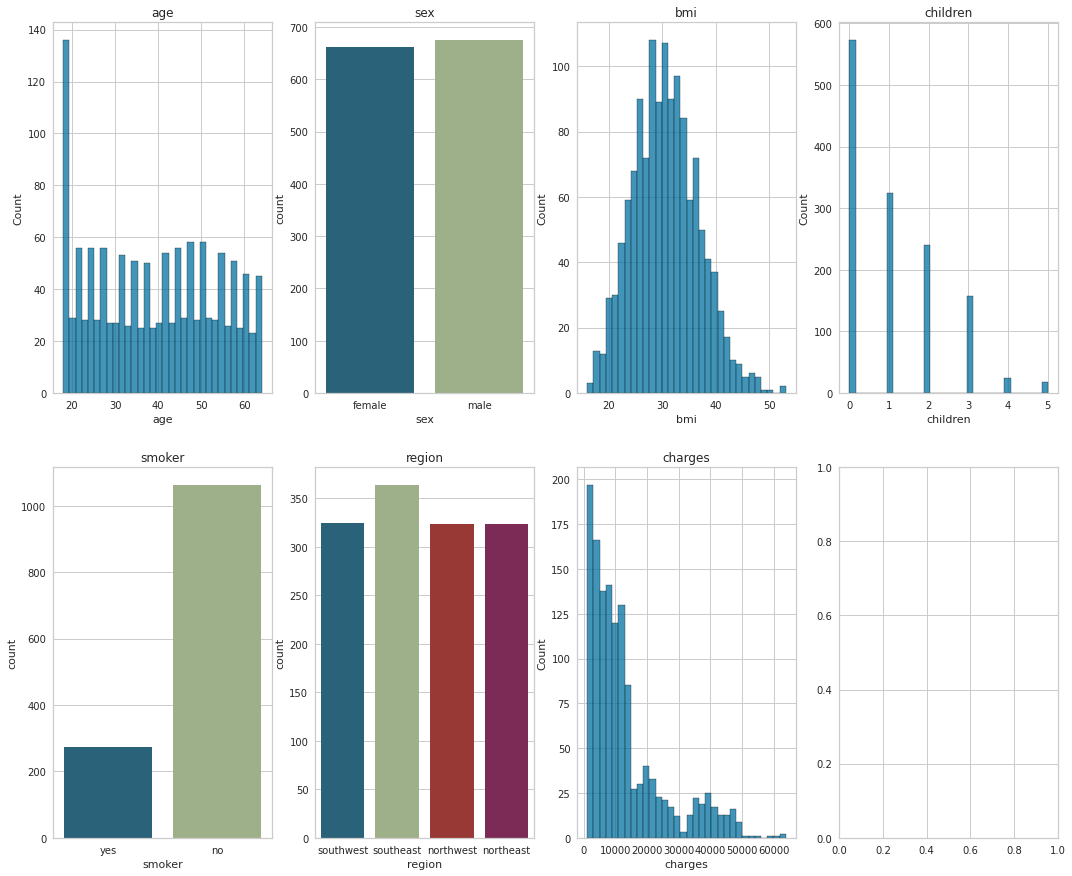

In [ ]:
sns.set_style()
fig, ax = plt.subplots(figsize=(18, 15), nrows=2, ncols=4)

idx=0
num_var, cat_var = get_type(health)

for col in health.columns:
  idx+=1
  plt.subplot(2, 4, idx)
  if col in num_var:
    sns.histplot(data=health, x=col, bins=32)
    plt.title(col, fontsize=12)
  else:
    sns.countplot(data=health, x=col, saturation=0.5)
    plt.title(col, fontsize=12)

As distribuições nos permitem tirar algumas conclusões interessantes.

* A idade tem uma distribuição muito constante, exceto para valores menores de idade.

* Há uma pequena quantidade maior de homens em relação a mulheres.

* O IMC tem uma distribuição aproximadamente normal.

* A maioria dos clientes não possuem crianças e a quantidade é decrescente até chegar a 5 crianças. Embora seja uma variável numérica, ela é uma variável discreta. Por isso, uma opção seria transformá-la em uma variável categórica e agrupar valores raros (como 4 e 5 filhos), o que pode ajudar a reduzir o "ruído" do modelo que será criado.

* A maioria dos clientes não são fumantes.

* As regiões são aproximadamente igualmente distribuídas. A região sudeste tem uma prevalência ligeiramente maior.

* Prêmios de seguro têm uma distribuição com alta prevalência dos menores valores e uma tendência decrescente até os valores mais altos. Note que ela não está normalmente distribuída, mas possui um esticamento para a direita. Isso pode ser tratado usando uma transformação da variável.




#### Resumo estatístico

Podemos utilizar um resumo estatístico para ver mais de perto as características descritivas gerais das variáveis numéricas.

In [ ]:
health.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


* Idade: a média de idade dos cliente e de 39 anos. O valor mínimo é 18 anos, ou seja, apenas maiores de idade podem ter seguros de saúde próprios. O valo máximo é de 64 anos.

* O IMC médio é de 30, o que caracteriza obesidade. Um pouco menos de 25% dos clientes estão em peso normal ou abaixo do normal. Portanto, um pouco mais de 75% dos clientes estão em sobrepeso ou pior. Em torno de 25% dos clientes mais obesos estão com obesidade severa ou mórbida.

* Os clientes, tem, em média, uma criança.

* A média do prêmio de seguro está próximo de 13200. A mediana é de 9300.

Agora, vamos olhar a distribuição das variáveis categóricas mais de perto.

In [ ]:
print(health['smoker'].value_counts() / len(health))
print(health['region'].value_counts() / len(health))
print(health['sex'].value_counts() / len(health))

no     0.795064
yes    0.204936
Name: smoker, dtype: float64
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: region, dtype: float64
male      0.504862
female    0.495138
Name: sex, dtype: float64


Isso confirma o que tínhamos visto no histograma.

### Respondendo algumas perguntas

#### Pessoas mais velhas tendem a ter um IMC maior?

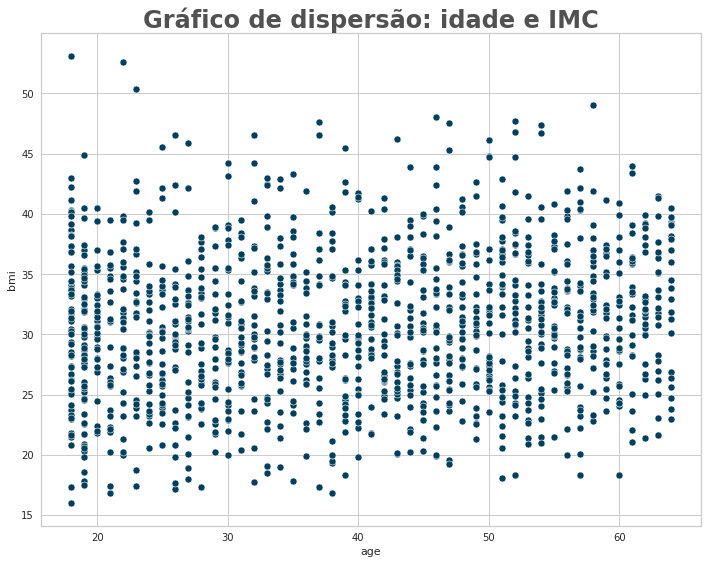

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=health, x='age', y='bmi', color=AZUL)
ax.set_title('Gráfico de dispersão: idade e IMC', fontsize=24, color=CINZA_TEXTO, weight='bold')
plt.tight_layout()

Uma breve observação no gráfico não aparenta indicar nenhuma relação significativa entre idade e IMC.

#### Qual o IMC médio por sexo? 

In [ ]:
health.groupby('sex').bmi.mean()

sex
female    30.377749
male      30.943652
Name: bmi, dtype: float64

O IMC para cada sexo é praticamente idêntico.

#### Idade de fumantes e não fumantes

In [ ]:
health.groupby('smoker').age.mean()

smoker
no     39.404516
yes    38.514599
Name: age, dtype: float64

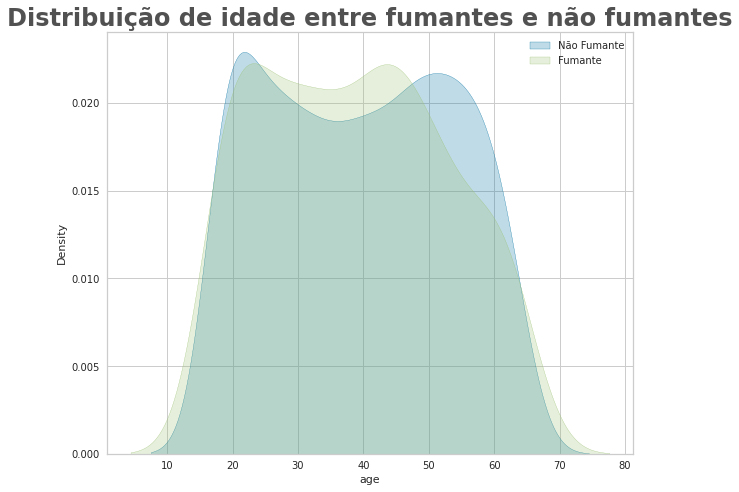

In [ ]:
smoker = health[health.smoker == 'yes']
not_smoker = health[health.smoker == 'no']

fig, ax = plt.subplots(figsize=(10,7))

sns.kdeplot(not_smoker['age'], label="Não Fumante", shade=True)
sns.kdeplot(smoker['age'], label='Fumante', shade=True)

ax.set_title('Distribuição de idade entre fumantes e não fumantes', fontsize=24, weight='bold', color=CINZA_TEXTO)
ax.legend()

plt.tight_layout()

A média de idade de fumantes e não fumantes é muito parecida, bem como as suas distribuições. A distribuição indica apenas uma pequena prevalência de fumantes entre 30 e 45 anos e de não fumantes entre 50 e 60 anos.

#### Há uma relação entre idade e prêmio de seguro?



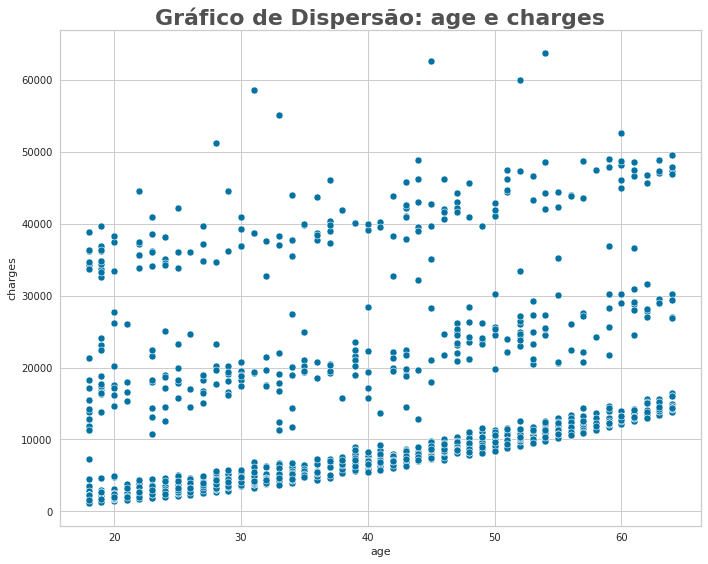

In [ ]:
scatter(data=health, x='age', y='charges')

Como se pode ver, há uma relação muito grande entre essas duas variáveis. É nítido também a presença de três conjunto de pontos agrupados que formam "retas" crescentes. O mais embaixo é o que se mais se destaca por sua grande linearidade.

O que explica essa divisão? Talvez haja uma outra variável no conjunto de dados -- provavelmente categórica -- que explique esse fenômeno.

Então, vamos estudar um pouco a relação entre a variável ``charges`` e outras variáveis do conjunto de dados.

#### ``charges`` e ``region``


<bound method Series.to_frame of region
northeast    13406.384516
northwest    12450.840844
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64>

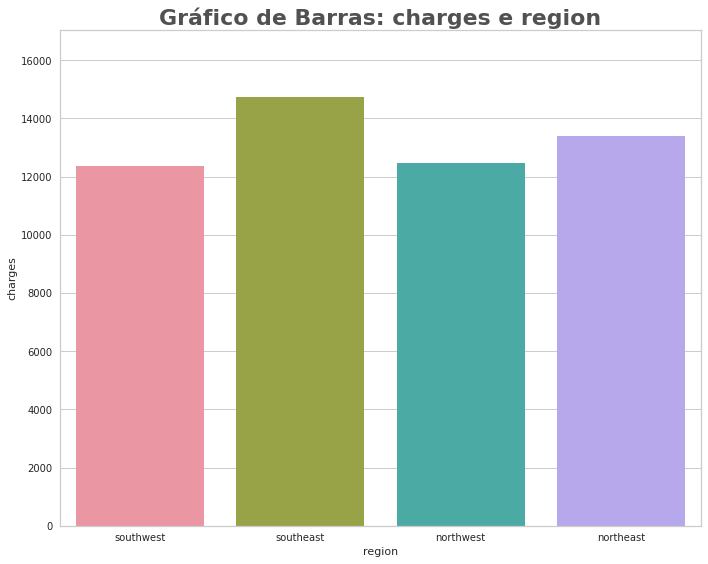

In [ ]:
group_by(health, 'charges', 'region')

Clientes do sudeste tendem a ter um valor maior para ``charges``, seguidos por clientes do nordeste. 

### ``charges`` e ``children``

<bound method Series.to_frame of children
0    12384.695344
1    12731.171832
2    15073.563734
3    15355.318367
4    13850.656311
5     8786.035247
Name: charges, dtype: float64>

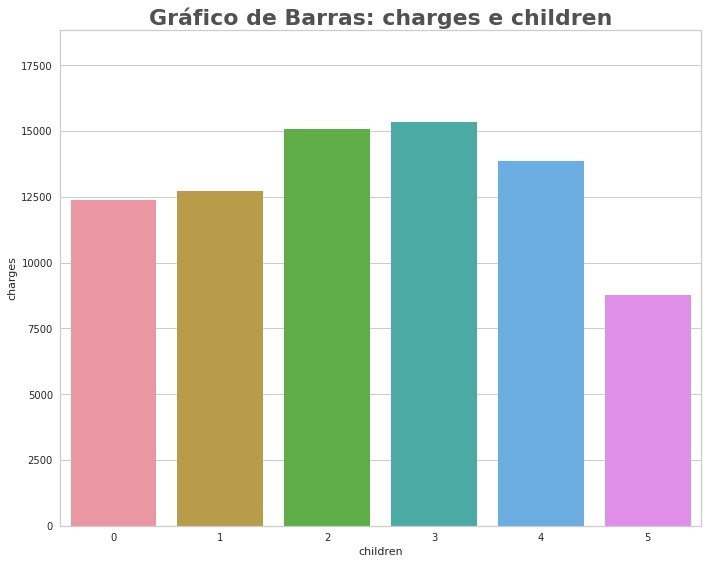

In [ ]:
group_by(health, 'charges', 'children')

#### ``charges`` e `smoker``

<bound method Series.to_frame of smoker
no      8440.660307
yes    32050.231832
Name: charges, dtype: float64>

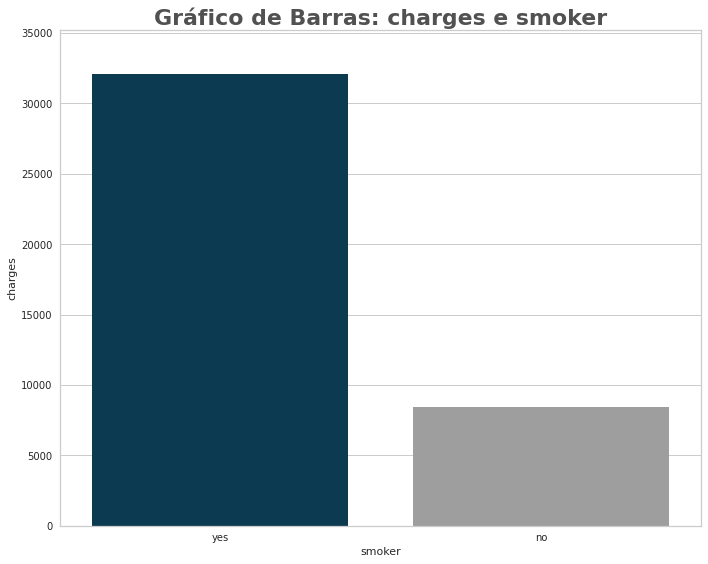

In [ ]:
group_by(health, 'charges', 'smoker')

A diferença entre fumantes e não fumantes é imensa! Fumantes têm um prêmio de seguro quase 4 vezes maior, em média. Vamos ver se essa é a variável que está criando o fenômeno observado no gráfico de dispersão.

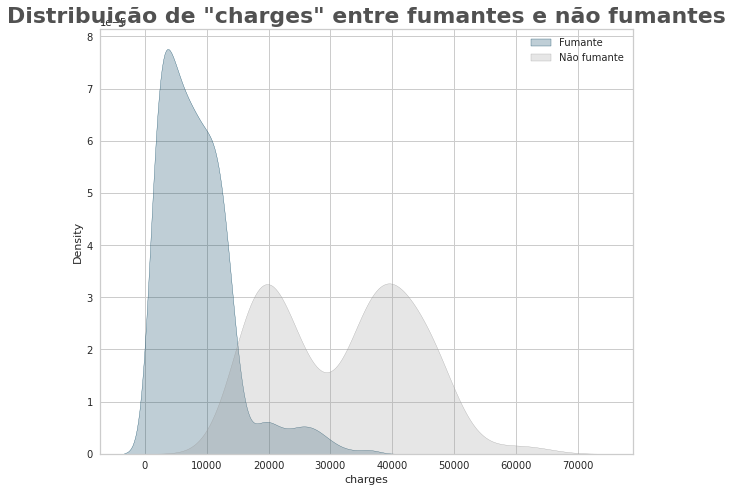

In [ ]:
smoker = health[health.smoker == 'yes']
not_smoker = health[health.smoker == 'no']

fig, ax = plt.subplots(figsize=(10,7))

sns.kdeplot(not_smoker['charges'], label="Fumante", shade=True)
sns.kdeplot(smoker['charges'], label='Não fumante', shade=True)

ax.set_title('Distribuição de "charges" entre fumantes e não fumantes', fontsize=22, weight='bold', color=CINZA_TEXTO)
ax.legend()

plt.tight_layout()

A distribuição reforça essa diferença entre fumantes e não fumantes.




### Idade e prêmio de seguro divididos por fumantes e não fumantes










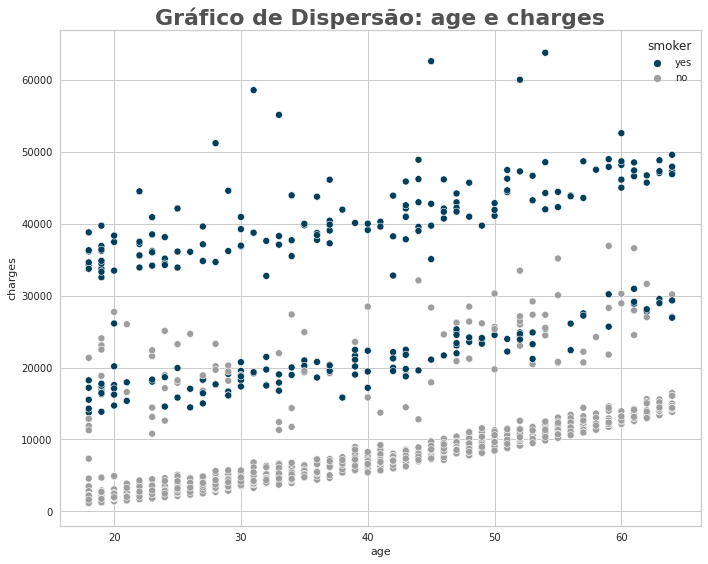

In [ ]:
scatter(data=health, x='age', y='charges', hue='smoker')

De fato, a diferença entre fumantes e não fumantes torna-se muito evidente no grafico. Não fumantes se concentram na parte inferior, enquanto fumantes tem naturalmente uma valor para prêmio de seguros maior.

Exceto para algumas observações, a relação entre idade e prêmio de seguro para não fumantes é quase que completamente linear.

Portanto, conseguimos concluir que:

* Fumar ou não é a característica mais determinante no valor do prêmio de seguro.

* A relação entre idade e valor do prêmio também é grande, e torna-se especialmente linear para não fumantes.


#### Relação entre IMC (``bmi``) e Prêmio de Seguro (``charges``)

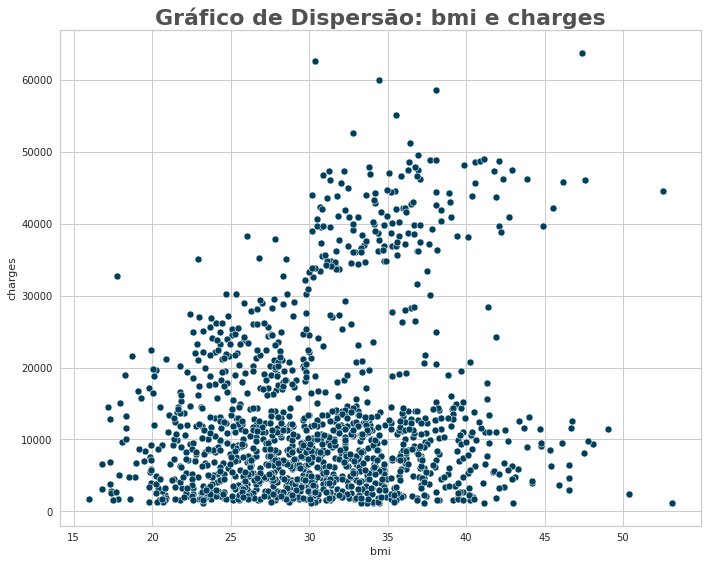

In [ ]:
scatter(data=health, x='bmi', y='charges')

Nós podemos ver também uma correlação positiva, embora não tão forte como a anterior.

Além disso, também podemos notar que uma parte dos dados parece seguir uma relação linear mais notável, enquanto outra parte parece se agrupar de forma horizontal no gráfico.

Novamente, isso pode ser explicado pelo caso de fumante e não fumantes.

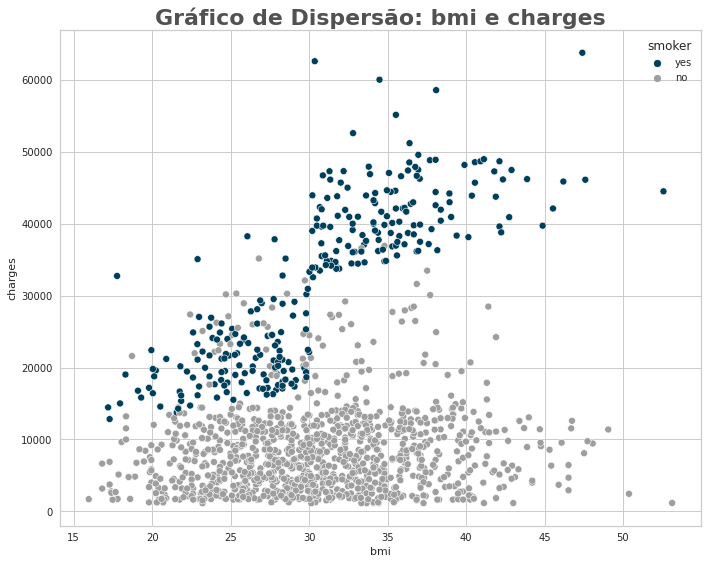

In [ ]:
scatter(data=health, x='bmi', y='charges', hue='smoker')

* Não fumantes se agrupam mais horizontalmente e não apresentam uma correlação positiva evidente pelo gráfico.

* Ao contrário, para não fumantes, a relação entre IMC e prêmio de seguro se mostra muito mais intensa.

### Correlações

Podemos agora visualizar as correlações entre as variáveis.

In [ ]:
corr = health.corr()

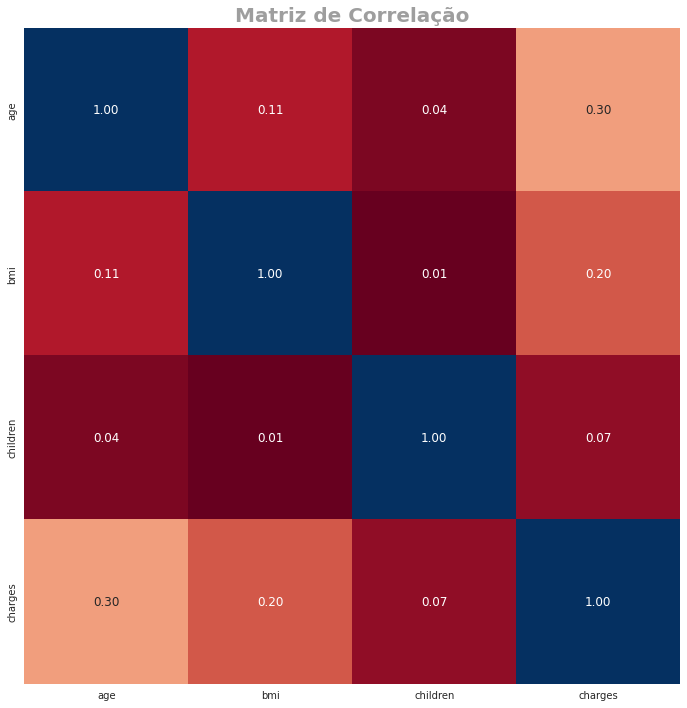

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title("Matriz de Correlação", fontsize=20, color=CINZA, weight='bold')
sns.heatmap(corr, cmap = 'RdBu', fmt = '.2f', square = True , linecolor = 'white', annot = True, cbar=False)
plt.tight_layout()

* A maior correlação é entre ``age`` e ``charges``, como já tínhamos visualizado no gráfico de dispersão. Seu valor é de 0,3.

* A correlação entre ``charges`` e ``bmi`` é de 0,2, indicando o que também visualizamos no gráfico de dispersão. 

Agora, vamos ver como essas correlações se comportam ao discriminarmos entre fumantes e não fumantes.

In [ ]:
no_smoke = health[health['smoker'] == 'no']
smoke = health[health['smoker'] == 'yes']

In [ ]:
print("Matriz de Correlação para Fumantes")
smoke.corr()

Matriz de Correlação para Fumantes


,age,bmi,children,charges
age,1.000000,0.059674,0.081183,0.368224
bmi,0.059674,1.000000,-0.012619,0.806481
children,0.081183,-0.012619,1.000000,0.035945
charges,0.368224,0.806481,0.035945,1.000000


In [ ]:
print("Matriz de Correlação para não Fumantes")
no_smoke.corr()

Matriz de Correlação para não Fumantes


,age,bmi,children,charges
age,1.000000,0.122745,0.032219,0.627400
bmi,0.122745,1.000000,0.019207,0.084077
children,0.032219,0.019207,1.000000,0.138109
charges,0.627400,0.084077,0.138109,1.000000


Como já esperado, as correlações se tornam muito mais evidentes quando efetuamos isso:

* Para fumantes, a correlação entre ``charges`` e ``age`` aumente de 0,3 para 0,36.

* Para fumantes, a correlação entre ``charges`` e ``bmi`` aumenta de 0,2 para 0,80.

* Em não fumantes, a correlação entre ``charges`` e ``age`` foi para 0,62

## AutoML

Feita essa análise exploratória, podemos seguir para de fato construir o modelo de machine learning com AutoML.

### Divisão treino-teste

Antes de tudo, vamos primeiro deixar um conjunto de testes separado para que ele não seja usado durante o treinamento.

In [ ]:
train = health.sample(frac=0.9)
test = health.drop(train.index)

test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

In [ ]:
print(train.shape, test.shape)

(1203, 7) (134, 7)


### Configurando o ambiente

Agora, iremos começar configurando todas as etapas de preprocessamento necessárias de serem feitas. Em geral, código abaixo realiza o seguinte:

* A variável alvo do problema é ``charges``, isto é, o valor do prêmio de seguro.

* Normalização dos dados. Importante para modelos que lidam com distância, como o K-Vizinhos mais Próximos e uma Máquina de Vetor de Suporte.

* Agrupa os valores da variável ``children``.

In [ ]:
reg = setup(data=train, target='charges', session_id=12 ,
            normalize=True, 
            log_experiment=True, experiment_name='health.01', 
            numeric_features = ['children'], bin_numeric_features=['children'])

,Description,Value
0,session_id,12
1,Target,charges
2,Original Data,"(1203, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(842, 14)"


INFO:logs:Logging experiment in MLFlow
2023/01/23 01:41:00 INFO mlflow.tracking.fluent: Experiment with name 'health.01' does not exist. Creating a new experiment.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['children'],
                                      target='charges', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeri...
                ('binn

### Comparando modelos

Feito o pré-processamento, agora iremos treinar os dados em vários modelos simples e observarmos aqueles com os melhores resultados.

Para avaliá-los, a principal métrica a ser levada em consideração será a $R^2$.


In [ ]:
best = compare_models(cross_validation=True, n_select=3, fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2617.6037,2.217916e+07,4676.5981,0.8441,0.4393,0.3047,0.114
lightgbm,Light Gradient Boosting Machine,2863.2801,2.423871e+07,4872.7378,0.8308,0.5190,0.3434,0.188
rf,Random Forest Regressor,2780.0972,2.443731e+07,4897.5678,0.8289,0.4713,0.3407,0.516
ada,AdaBoost Regressor,3947.1868,2.636211e+07,5110.1668,0.8138,0.5828,0.6323,0.058
et,Extra Trees Regressor,2786.6897,2.835296e+07,5264.2637,0.8023,0.4631,0.3064,0.436
llar,Lasso Least Angle Regression,4211.0226,3.666871e+07,6027.7502,0.7405,0.6020,0.4328,0.046
ridge,Ridge Regression,4230.7365,3.669724e+07,6029.7177,0.7404,0.5952,0.4365,0.028
br,Bayesian Ridge,4227.7603,3.669449e+07,6029.6118,0.7404,0.5978,0.4360,0.026
lasso,Lasso Regression,4218.6294,3.669224e+07,6029.7116,0.7403,0.6039,0.4343,0.026
lr,Linear Regression,4219.7531,3.669784e+07,6030.2312,0.7403,0.5991,0.4344,1.082


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=12, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_

Os modelos que tiveram uma melhor performance foram: 

* Gradient Boosting

* Random Forest

* Light Gradient Boosting

Todos esses modelos têm em comum o fato de serem modelos baseados em árvores de decisão e serem *ensembles*. Em outras palavras, eles são formados a partir combinação de múltiplas árvores de decisão.

Nesse projeto, vamos escolher esses três melhores algorítmos e escolheremos aquele que tiver a melhor performance após o *tuning* dos hiperparâmetros.

### Gradient Boosting Regressor

Primeiro, vamos treinar o **Gradient Boosting Regressor**

In [ ]:
tuned_gbr = get_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2783.4441,2.507522e+07,5007.5164,0.8142,0.5644,0.3377
1,2692.8663,2.770145e+07,5263.2167,0.8562,0.4163,0.2697
2,2542.7593,2.104402e+07,4587.3761,0.8319,0.4684,0.2884
3,2747.7742,2.440167e+07,4939.8049,0.8164,0.4694,0.3313
4,2385.2099,1.579590e+07,3974.4057,0.8441,0.5175,0.3663
5,2705.3852,1.746967e+07,4179.6733,0.8435,0.4187,0.3133
6,2708.9349,2.291923e+07,4787.4029,0.8520,0.3984,0.3309
7,2875.1548,2.111652e+07,4595.2714,0.8460,0.4921,0.4114
8,3128.0718,3.560090e+07,5966.6488,0.7878,0.5496,0.3252


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 4
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.001, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=12, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
print(tuned_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.001, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=12, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


### Avaliando o modelo

Criado o modelo, podemos ver como visualizar a sua performance e características gerais com alguns gráficos.

#### Previsões e erros

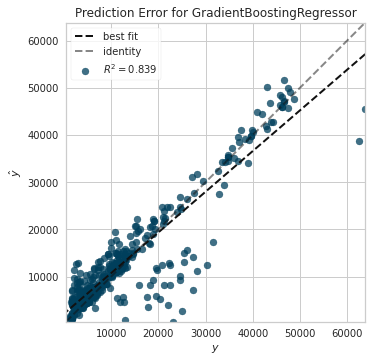

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbr, plot='error')

#### Residuais

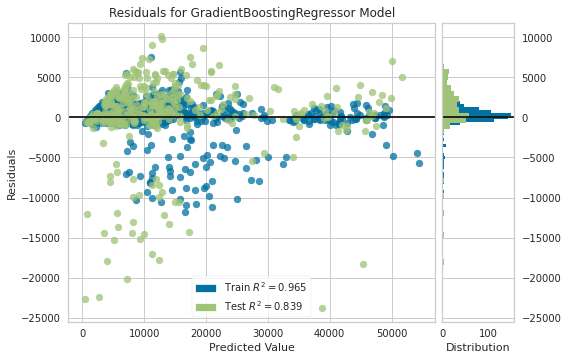

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbr, plot='residuals')

#### Feature Importance

Como já era de se esperar, as features mais relevantes são:

* Se o cliente é ou não fumante

* A idade do cliente

* O IMC do cliente

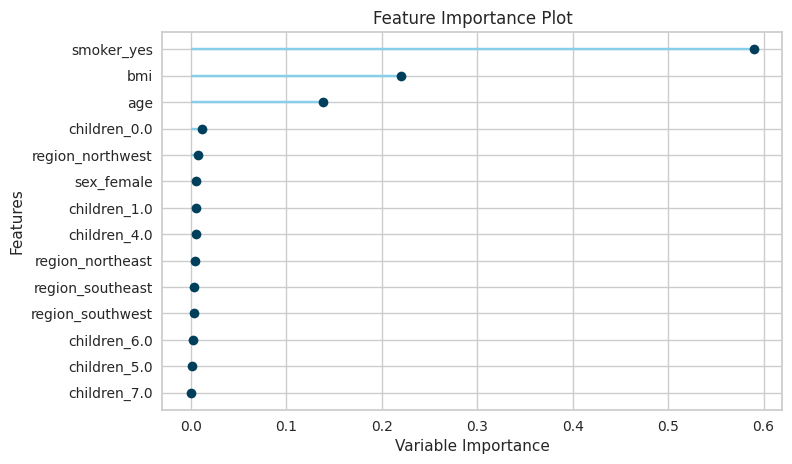

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbr, plot='feature_all')

#### Visão Geral

In [ ]:
evaluate_model(tuned_gbr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.001, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=12, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Random Forest

Vamos aplicar o mesmo processo para a random forest.


In [ ]:
tuned_rf = get_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2384.4885,2.078405e+07,4558.9528,0.8460,0.5018,0.2822
1,2709.0248,2.746752e+07,5240.9466,0.8574,0.3960,0.2629
2,2407.6748,1.773712e+07,4211.5464,0.8583,0.4131,0.2728
3,2447.7363,1.883395e+07,4339.8094,0.8583,0.3976,0.3128
4,2016.3189,1.138104e+07,3373.5791,0.8877,0.4091,0.2953
5,2595.1762,1.739019e+07,4170.1552,0.8442,0.3867,0.2946
6,2420.0211,1.967565e+07,4435.7238,0.8729,0.4033,0.3412
7,2495.9275,1.560719e+07,3950.5934,0.8862,0.4272,0.3647
8,2771.5556,2.882811e+07,5369.1811,0.8282,0.4466,0.2410


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 6
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


Agora, a otimização de hiperparâmetros resultou em uma melhora de desempenho do modelo.





### Avaliando Random Forest

#### Random Forest -- Erro de Previsão

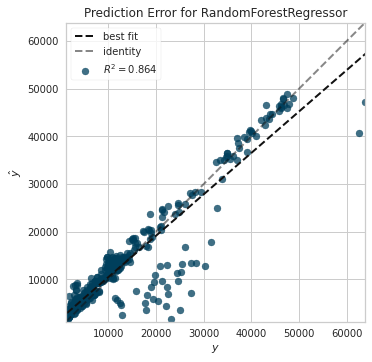

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot='error')

#### Random Forest -- Residuais

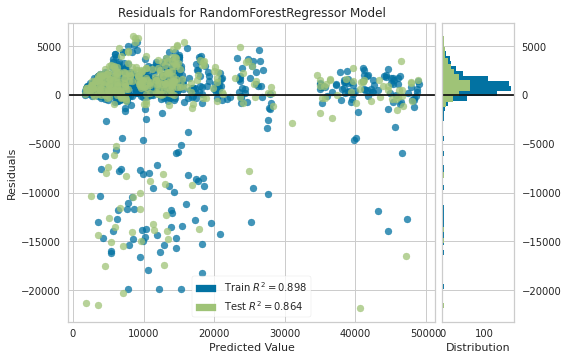

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot='residuals')

#### Random Forest -- Feature Importance

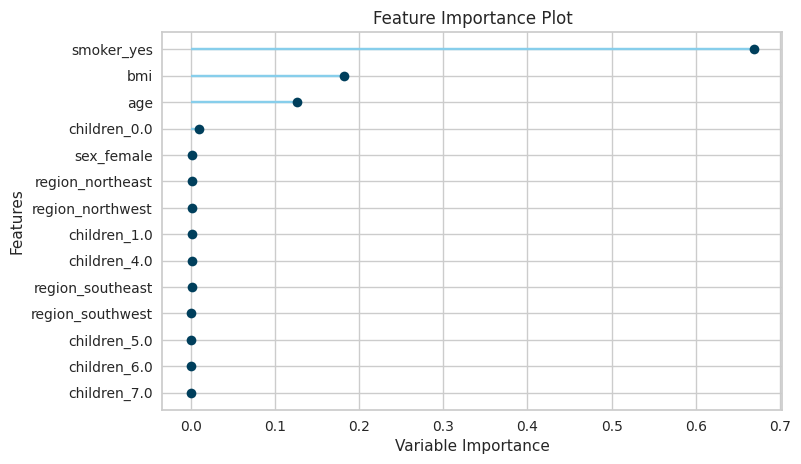

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot='feature_all')

#### Random Forest -- Visão Geral

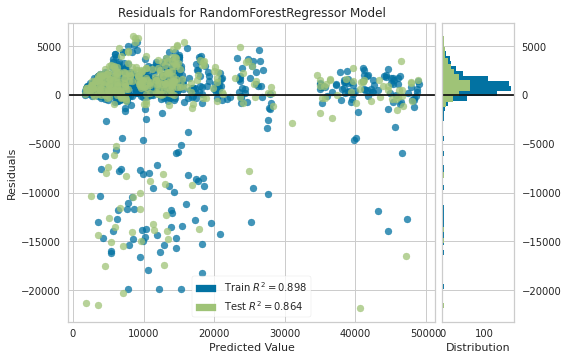

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf)

In [ ]:
evaluate_model(tuned_rf)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=12, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### LightGBM

Novamente, vamos aplicar o procedimento para o ***Light Gradient Boosting***

In [ ]:
tuned_lgbm = get_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2837.8554,2.493591e+07,4993.5873,0.8152,0.6164,0.3363
1,2854.7144,2.651585e+07,5149.3547,0.8623,0.4342,0.2720
2,2655.0543,2.047390e+07,4524.8093,0.8365,0.4765,0.2834
3,2786.9137,2.279564e+07,4774.4784,0.8284,0.4176,0.3242
4,2156.9568,1.237346e+07,3517.5936,0.8779,0.4335,0.3349
5,2578.9051,1.600709e+07,4000.8862,0.8566,0.4272,0.2968
6,2912.1987,2.339151e+07,4836.4769,0.8489,0.4813,0.3912
7,2827.0875,1.792178e+07,4233.4126,0.8693,0.4334,0.3656
8,3126.7552,3.156306e+07,5618.1012,0.8119,0.4632,0.2687


INFO:logs:create_model_container: 24
INFO:logs:master_model_container: 24
INFO:logs:display_container: 8
INFO:logs:LGBMRegressor(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=51, min_child_weight=0.001, min_split_gain=0.3,
              n_estimators=200, n_jobs=-1, num_leaves=20, objective=None,
              random_state=12, reg_alpha=1e-06, reg_lambda=4, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


### Avaliando Light Boosting Regressor

#### LGBM - Erro de Previsão

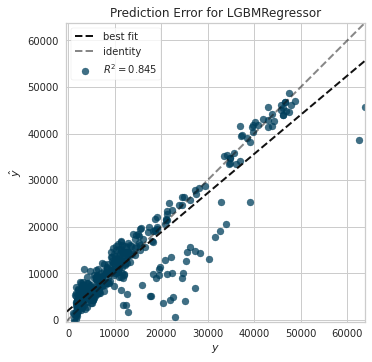

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lgbm, plot='error')

#### LGBM -- Residuais

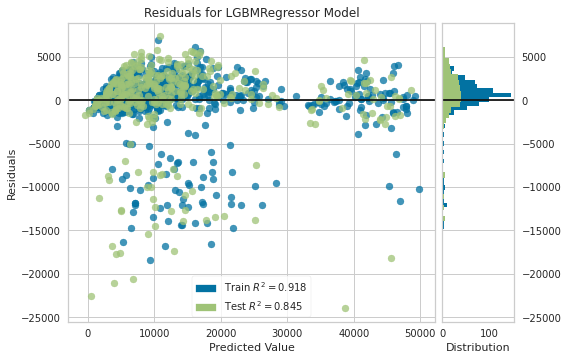

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lgbm, plot='residuals')

#### LGBM -- Feature Importance

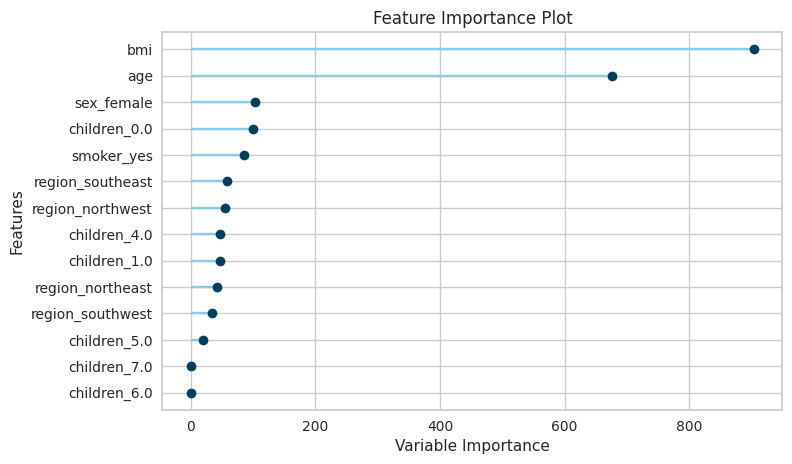

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lgbm, plot='feature_all')

##### LGBM -- Visão Geral

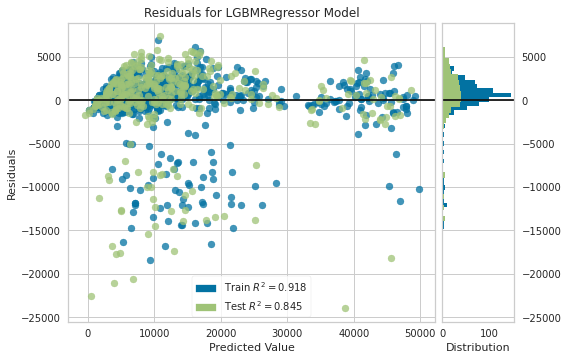

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lgbm)

## Escolhendo o melhor modelo

Os resultados da validação cruzada nos mostraram que o melhor modelo com *tuning* foi a random forest. Por isso, vamos prosseguir com esse algorítmo.

### Fazendo previsões

Agora, podemos usar a random forest para fazer previsões no conjunto de testes separado pelo Pycaret.

In [ ]:
predict_model(tuned_rf)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=12, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2620.9605,2.122858e+07,4607.448,0.8644,0.4453,0.3072


,age,bmi,sex_female,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,children_0.0,children_1.0,children_4.0,children_5.0,children_6.0,children_7.0,charges,Label
0,0.044695,-0.696219,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6389.377930,6728.691901
1,1.417114,0.131441,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12622.179688,12771.370566
2,0.044695,0.365684,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,39125.332031,39446.304014
3,-0.966561,2.626747,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2927.064697,5756.532776
4,1.706044,-0.461976,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29523.166016,28373.238115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.116928,1.076632,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7371.771973,9314.044849
357,0.044695,-0.205541,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,15828.821289,7526.262059
358,-1.544421,-0.537591,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,18223.451172,16872.604203
359,1.200416,0.203768,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,43813.867188,44747.371972


### Finalizando o Modelo e prevendo em novos dados

Agora, vamos finalizar o modelo e aplicá-lo no conjunto de testes separado no início do projeto para verificar a sua performance.

In [ ]:
final_rf = finalize_model(tuned_rf)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=12, verbose=0, warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
               

In [ ]:
new_predictions = predict_model(final_rf, data=test)
new_predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=12, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2269.8666,1.565494e+07,3956.6327,0.8891,0.3772,0.2926


,age,sex,bmi,children,smoker,region,charges,Label
0,46,female,33.44,1,no,southeast,8240.5896,9021.283399
1,37,male,29.83,2,no,northeast,6406.4107,8694.672784
2,56,female,39.82,0,no,southeast,11090.7178,13378.429858
3,52,female,30.78,1,no,northeast,10797.3362,14145.609127
4,56,male,40.30,0,no,southwest,10602.3850,12466.779294


## Conclusões

O objetivo deste projeto foi explorar as possibilidades e o desempenho da recente técnica de "Auto Machine Lerning". Usando-o, pudemos gastar menos tempo no processo de construção de modelos de aprendizado de máquina e, em vez disso, nos concentramos em explorar o problema e extrair insights dos dados disponíveis. A partir desses insights, identificamos as principais transformações necessárias a serem aplicadas no conjunto de dados e pudemos testar o desempenho de vários algoritmos de aprendizado de máquina, escolhendo aqueles com melhor desempenho.

Em síntese, vimos como o auto aprendizado de máquina pode otimizar o tempo de um cientista de dados e deixá-lo mais preocupado com tarefas mais focadas no problema específico que ele está tentando resolver e que não podem ser automatizadas.